In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
import time
import plotly.express as px
from sklearn.inspection import permutation_importance

# Question 1

In [2]:
data = [
    [1, 'Milk', 'Bread', 'Butter', 0],
    [2, 'Milk', 'Bread', 0, 0],
    [3, 'Bread', 'Butter', 'Eggs', 0],
    [4, 'Milk', 'Butter', 0, 0],
    [5, 'Bread', 'Eggs', 0, 0],
    [6, 'Milk', 'Bread', 'Butter', 'Eggs'],
    [7, 'Bread', 'Butter', 0, 0],
    [8, 'Milk', 'Eggs', 0, 0],
    [9, 'Milk', 'Bread', 0, 0],
    [10, 'Bread', 'Butter', 'Eggs', 0],
]

#i'm filling some of the transactions with zeros so that the samples have the same amount of columns 

columns = ['TID', 1, 2, 3, 4]

In [3]:
df = pd.DataFrame(data, columns = columns)
df

TID      1       2       3     4
0    1   Milk   Bread  Butter     0
1    2   Milk   Bread       0     0
2    3  Bread  Butter    Eggs     0
3    4   Milk  Butter       0     0
4    5  Bread    Eggs       0     0
5    6   Milk   Bread  Butter  Eggs
6    7  Bread  Butter       0     0
7    8   Milk    Eggs       0     0
8    9   Milk   Bread       0     0
9   10  Bread  Butter    Eggs     0

In [4]:
#transforming the dataframe so that the items in each transaction are represented by 1's or 0's
#the apriori command requires the data to be in this format 

itemset = set(['Bread', 'Milk', 'Butter', 'Eggs'])
encoded_vals = []
for index, row in df.iterrows():
    rowset = set(row)
    labels = {}
    uncommons = list(itemset - rowset)
    commons = list(itemset.intersection(rowset))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)

ohe_df = pd.DataFrame(encoded_vals)

ohe_df.head()

Eggs  Bread  Butter  Milk
0     0      1       1     1
1     0      1       0     1
2     1      1       1     0
3     0      0       1     1
4     1      1       0     0

In [5]:
#I'm timing my models to compare the computational efficiency 

start_time_apriori = time.time()
freq_items = apriori(ohe_df, min_support=0.4, use_colnames=True, verbose=1, max_len=3)
#apriori command returns the support for each frequent itemset 

print(freq_items)
end_time_apriori = time.time()
elapsed_time_apriori = end_time_apriori - start_time_apriori
print('The elapsed time was:', elapsed_time_apriori)

Processing 9 combinations | Sampling itemset size 3
   support         itemsets
0      0.5           (Eggs)
1      0.8          (Bread)
2      0.6         (Butter)
3      0.6           (Milk)
4      0.4    (Bread, Eggs)
5      0.5  (Bread, Butter)
6      0.4    (Bread, Milk)
The elapsed time was: 0.002228975296020508


/Users/melinakopischkie/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [6]:
#measureing the time it takes for the fp growth algorithm to return the frequent itemsets
start_time_fpg = time.time()
freq_items_fpg = fpgrowth(ohe_df, min_support=0.4, use_colnames=True, verbose=0, max_len=3)
#similar to apriori, the fpgrowth returns the support and the frequent itemsets 

print(freq_items_fpg)
end_time_fpg = time.time()
elapsed_time_fpg = end_time_fpg - start_time_fpg
print('The elapsed time was:', elapsed_time_fpg)

   support         itemsets
0      0.8          (Bread)
1      0.6           (Milk)
2      0.6         (Butter)
3      0.5           (Eggs)
4      0.4    (Bread, Milk)
5      0.5  (Bread, Butter)
6      0.4    (Bread, Eggs)
The elapsed time was: 0.001271963119506836


/Users/melinakopischkie/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [7]:
#creating a visualization for the fp growth tree
table = {
    'Items': ['Milk', 'Eggs', 'Bread', 'Butter'],
    'Incident Count': [ohe_df['Milk'].sum(), ohe_df['Eggs'].sum(), ohe_df['Bread'].sum(), ohe_df['Butter'].sum()]
}
df_table = pd.DataFrame(table)
#the table requires a common starting point (top items)
df_table['all'] = 'Top items'

plt.figure(figsize=(6, 4))
fig = px.treemap(df_table, path=['all', "Items"], values='Incident Count',
                  color=df_table["Incident Count"], hover_data=['Items'],
                  color_continuous_scale='Blues',
                )
fig.show()

<Figure size 600x400 with 0 Axes>

### Analysis

The FP Growth algorithm performed slightly faster by about 0.001 seconds. However, both the FP Growth and Apriori algorithm's yielded the same frequent item sets. Since this was a small dataset, the difference in performance time could grow when using a larger dataset, significantly impacting the choice of algorithm. We expect this result because the apriori algorithm requires multiple scans of the dataset to determine the frequent patterns. The apriori method finds all the frequent itemsets that satisfy the given minimum support and continues to generate the association rules from the frequent itemsets by using the mimimum support. Essentially, the computer scans the dataset once to find the frequent 1-itemsets, then makes combinations and scans the data again to determine what frequent 2-itemsets satisfy the minimum support, and so on. 

The FP Growth algorithm is generally faster than Apriori because it only requires two scans of the data. It works by dividing the data into partitions, scanning to find the frequent itemsets local to each partition, combining the local frequent itemsets to form a candidate itemset, and finding the gloval frequent itemsets among the candidates by scanning again. Therefore, with a larger dataset, we would see this method performing much faster than Apriori, but they both yield the same results. 

# Question 2

In [8]:
firedf = pd.read_csv('forestfires.csv')
firedf.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

In [9]:
#determining if there are any null values

firedf.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [10]:
firedf.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

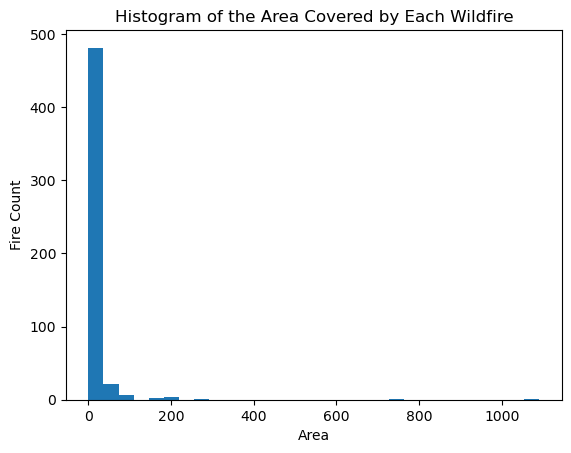

In [11]:
#doing EDA to determine if the target variable is skewed

plt.hist(firedf['area'], bins=30)
plt.title('Histogram of the Area Covered by Each Wildfire')
plt.ylabel('Fire Count')
plt.xlabel('Area')
plt.show()

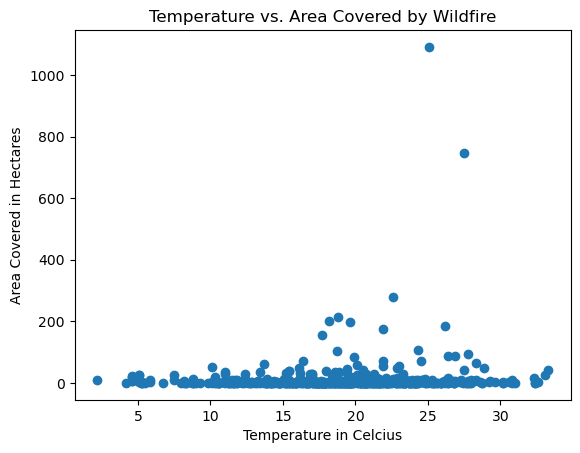

In [12]:
plt.scatter(firedf['temp'], firedf['area'])
plt.title('Temperature vs. Area Covered by Wildfire')
plt.ylabel('Area Covered in Hectares')
plt.xlabel('Temperature in Celcius')
plt.show()

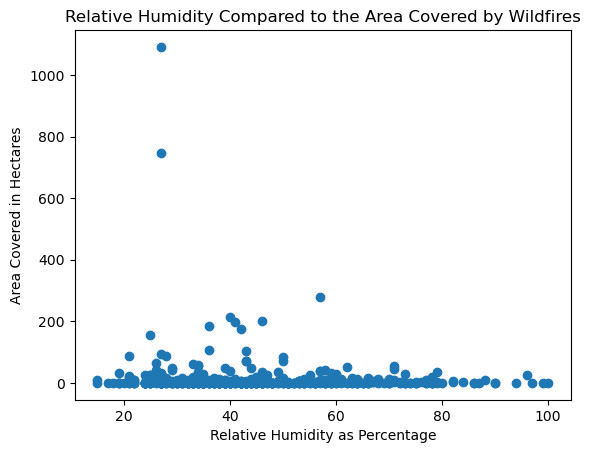

In [13]:
plt.scatter(firedf['RH'], firedf['area'])
plt.title('Relative Humidity Compared to the Area Covered by Wildfires')
plt.ylabel('Area Covered in Hectares')
plt.xlabel('Relative Humidity as Percentage')
plt.show()

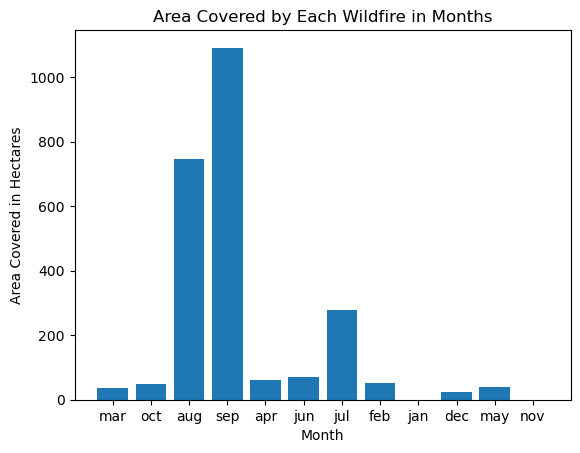

In [14]:
plt.bar(firedf['month'], firedf['area'])
plt.title('Area Covered by Each Wildfire in Months')
plt.ylabel('Area Covered in Hectares')
plt.xlabel('Month')
plt.show()

In [15]:
#using the describe command to find information such as mean, median, and standard deviation 
#of each numeric attribute

firedf.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655818  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.520000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

In [16]:
#encoding the months and the days when a wildfire occured 
#label encoding provides each month and day with a numerical attribute 

label_encoder = LabelEncoder()

firedf['month_encoded'] = label_encoder.fit_transform(firedf['month'])
firedf['day_encoded'] = label_encoder.fit_transform(firedf['day'])
firedf.drop(['month', 'day'], axis=1, inplace=True)
firedf.head()

X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  month_encoded  \
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0              7   
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0             10   
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0             10   
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0              7   
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0              7   

   day_encoded  
0            0  
1            5  
2            2  
3            0  
4            3

In [17]:
firedf.head()

X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  month_encoded  \
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0              7   
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0             10   
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0             10   
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0              7   
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0              7   

   day_encoded  
0            0  
1            5  
2            2  
3            0  
4            3

In [18]:
#checking to make sure that I have no more object types 

firedf.dtypes

X                  int64
Y                  int64
FFMC             float64
DMC              float64
DC               float64
ISI              float64
temp             float64
RH                 int64
wind             float64
rain             float64
area             float64
month_encoded      int64
day_encoded        int64
dtype: object

In [19]:
#splitting up my target variable from the rest of the data 

X = firedf.drop(['area'], axis=1)
y = firedf['area']

#since I have a skewed target variable, I'm using the logarithm transform to help the skewness 
y_log = np.log1p(y)

scaler = StandardScaler()

#splitting up my training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=123)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#using inverse frequency weighting to use in the decision tree regressor
#gives more weight to the target variable values that don't occur as often 
unique, counts = np.unique(y_train, return_counts=True)
weights = {v: 1.0 / c for v, c in zip(unique, counts)}

#sample weights for the training data 
sample_weights = np.array([weights[val] for val in y_train])

X_train_df = pd.DataFrame(X_train)

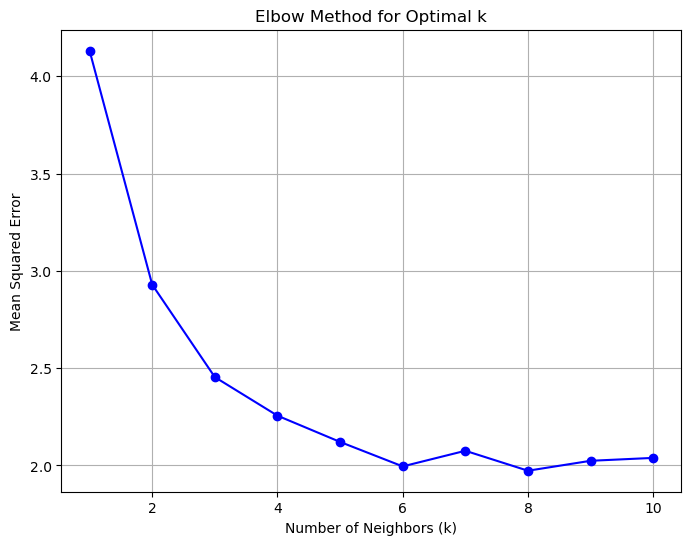

In [20]:
#elbow method to tune the hyperparameters to get the optimal k neighbors 

errors = []
k_values = range(1, 11)  

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)

plt.figure(figsize=(8, 6))
plt.plot(k_values, errors, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()

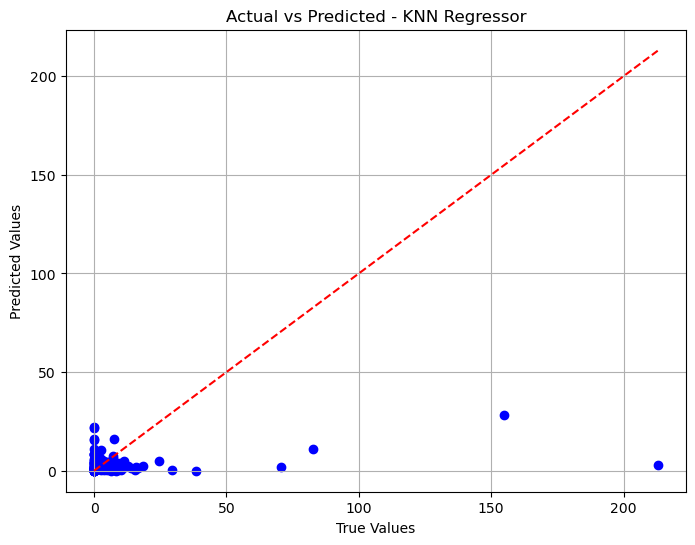

In [23]:
k = 3
#using weighted distance to help with the skewness 
knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn_regressor.fit(X_train, y_train)
y_pred_knn_log = knn_regressor.predict(X_test)

#since I was using the logarithm transform I'm reverting it back to the original to graph 
y_test_original = np.expm1(y_test)
y_pred_knn_original = np.expm1(y_pred_knn_log) 

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_knn_original, color='blue')
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - KNN Regressor')
plt.grid()
plt.show()

Mean Absolute Error (MAE): 1.1354006792442575
Mean Squared Error (MSE): 2.14418363720465
Root Mean Squared Error (RMSE): 1.4643031234019308
R-squared (R^2): -0.2707911199297701


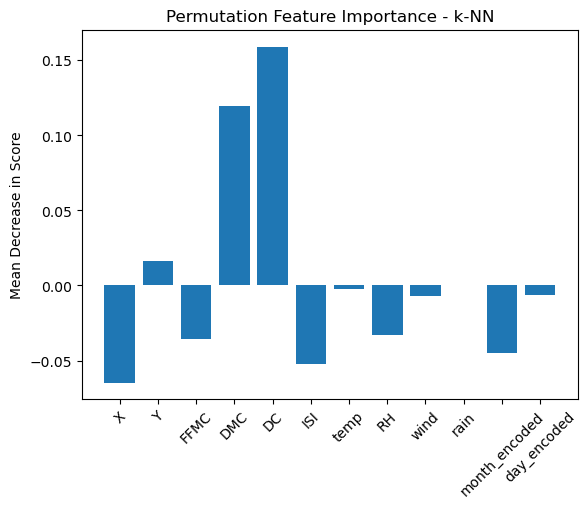

In [25]:
mae_knn = mean_absolute_error(y_test, y_pred_knn_log)
print("Mean Absolute Error (MAE):", mae_knn)

mse_knn = mean_squared_error(y_test, y_pred_knn_log)
print("Mean Squared Error (MSE):", mse_knn)

rmse_knn = np.sqrt(mse_knn)
print("Root Mean Squared Error (RMSE):", rmse_knn)

r2_knn= r2_score(y_test, y_pred_knn_log)
print("R-squared (R^2):", r2_knn)

#permutation importance evaluates each attributes' importance to the target variable by evaluating the model 
#performance when the features are shuffled 
result = permutation_importance(knn_regressor, X_test, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
plt.bar(X_train.columns, importances)
plt.title('Permutation Feature Importance - k-NN')
plt.xticks(rotation=45)
plt.ylabel('Mean Decrease in Score')
plt.show()

The permutation feature importance allows us to comprehend that the DMC and DC contributes most to this models performance. The DMC is the average rating of the moisture content and the DC is the drought code. 

In [26]:
#tuning the hyperparameters for the svr

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1]
}

#using cross validation to find the hyperparameters that perform the best 
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
best_svr = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}


/Users/melinakopischkie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



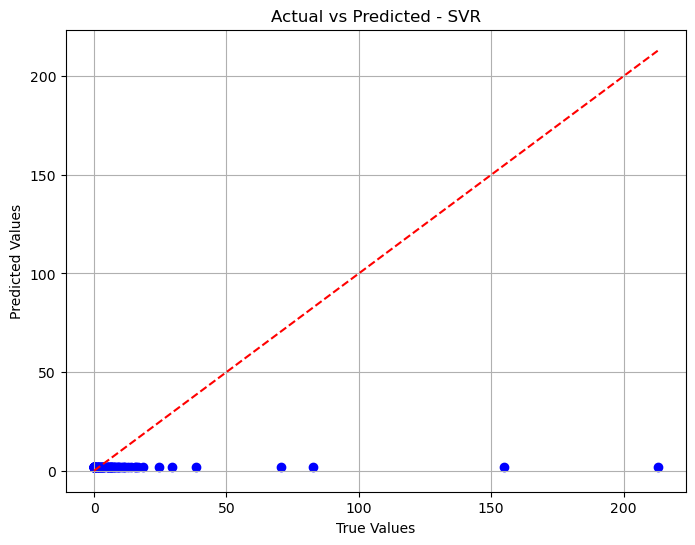

In [33]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=1.0)
svr_model.fit(X_train, y_train)
y_pred_svr_log = svr_model.predict(X_test_scaled)

#reverting out of the logarithm transform to graph the results 
y_test_original = np.expm1(y_test)
y_pred_svm_original = np.expm1(y_pred_svr_log) 

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_svm_original, color='blue')
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - SVR')
plt.grid()
plt.show()

Mean Absolute Error (MAE): 1.091352374433065
Mean Squared Error (MSE): 1.6962469258913575
Root Mean Squared Error (RMSE): 1.3024004475933497
R-squared (R^2): -0.0053129280666976975


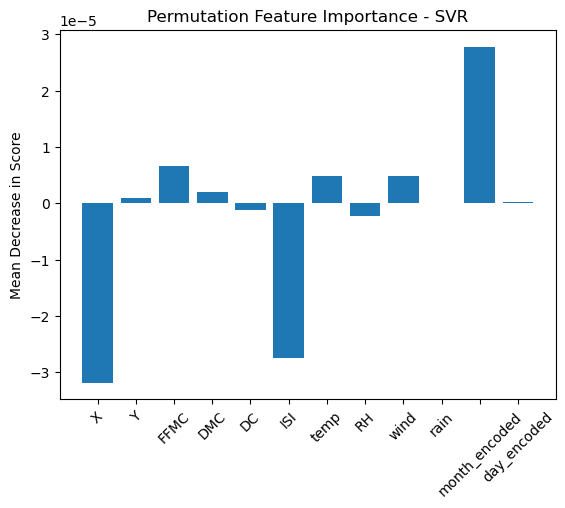

In [34]:
mae_svr = mean_absolute_error(y_test, y_pred_svr_log)
print("Mean Absolute Error (MAE):", mae_svr)

mse_svr = mean_squared_error(y_test, y_pred_svr_log)
print("Mean Squared Error (MSE):", mse_svr)

rmse_svr = np.sqrt(mse_svr)
print("Root Mean Squared Error (RMSE):", rmse_svr)

r2_svr= r2_score(y_test, y_pred_svr_log)
print("R-squared (R^2):", r2_svr)

result = permutation_importance(svr_model, X_test, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
plt.bar(X_train.columns, importances)
plt.title('Permutation Feature Importance - SVR')
plt.xticks(rotation=45)
plt.ylabel('Mean Decrease in Score')
plt.show()

The most important feature in the SVR model is the month, which makes since given that we previously saw differences in the area covered by forest fires when comparing month to month

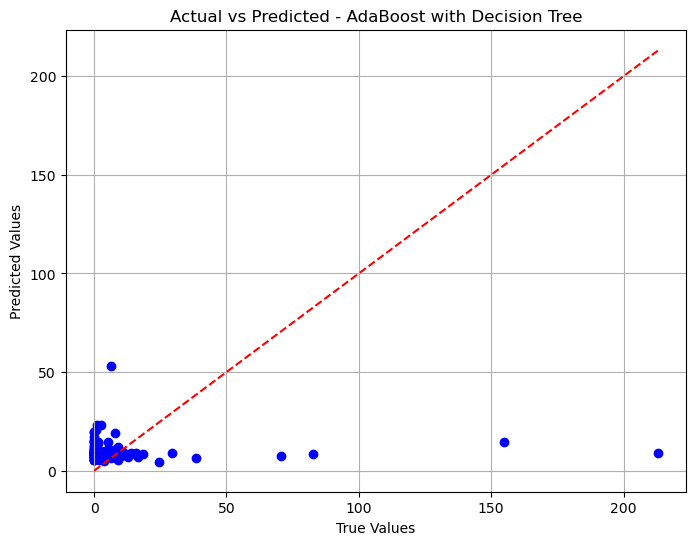

In [35]:
dt_model = DecisionTreeRegressor(max_depth=3)
#using boosting so that the models learn in order 
#increases the accuracy 
#adjusting the learning rate to increase the accuracy 
#using sample weights to give more weight to the target variables that occur less frequently 
ada = AdaBoostRegressor(dt_model, n_estimators=500, learning_rate=0.1)
ada.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred_dt_log = ada.predict(X_test_scaled)

#reverting out of the logarithm transform to graph the results 
y_test_original = np.expm1(y_test)
y_pred_dt_original = np.expm1(y_pred_dt_log) 

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_dt_original, color='blue')
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - AdaBoost with Decision Tree')
plt.grid()
plt.show()

Mean Absolute Error (MAE): 1.5908182869755068
Mean Squared Error (MSE): 3.3448272915519217
Root Mean Squared Error (RMSE): 1.8288868996064032
R-squared (R^2): -0.982375364707269


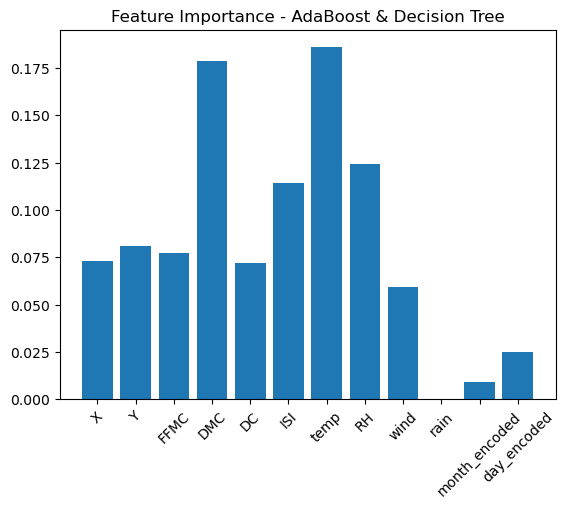

In [70]:
mae_dt = mean_absolute_error(y_test, y_pred_dt_log)
print("Mean Absolute Error (MAE):", mae_dt)

mse_dt = mean_squared_error(y_test, y_pred_dt_log)
print("Mean Squared Error (MSE):", mse_dt)

rmse_dt = np.sqrt(mse_dt)
print("Root Mean Squared Error (RMSE):", rmse_dt)

r2_dt = r2_score(y_test, y_pred_dt_log)
print("R-squared (R^2):", r2_dt)

feature_importance_dt = ada.feature_importances_

plt.bar(X_train.columns, feature_importance_dt)
plt.title('Feature Importance - AdaBoost & Decision Tree')
plt.xticks(rotation=45)
plt.show()

The generic feature importance command for regression models givs us information on how relevant each feature is to the performance of the model. Here, we see that the DMC (moisure compostion), temperature, and the relative humidity all have a larger affect on the adaboost/decision tree performance 

### Analysis

Neither the KNN, SVR, or decision tree regressor were able to accurately predict the area covered by a wildfire. I believe that this is because the data is so extremely skewed, that the model does not have enough instances of training data where large forest fires occured. So as of now, unfortunately a machine learning model is not a better predictor than guessing which forest fires will cover the most amount of area. When the model has more data, it will be vital in preventitive firefighting and minimizing the damages of wildfires. With more data, we can use each of these models to determine if there is a high risk of forest fire based on the more important features to each model. But for now, we see that the SVR has the highest R^2 score when it basically predicts a constant value. So we're unable to gather any actionable insight from this dataset. 

# Question 3

In [37]:
#i'm randomly creating this data by hand because if we want to observe trends that correlate to delayed deliveries, 
#we need to introduce bias
#for the distance, I'm randomly selecting a number that comes from a normal distribution with a mean of 50 
#and standard deviation of 10 - i'm using the normal distribution because I assume if a company is offering 
#deliveries, the majority of customers will be within a reasonable range 
#for vehicle, i'm randomly imputing truck, van, bike, or sedan, with reasonable inconsistencies to 
#represent real data
#for the weather, i'm randomly imputing sunny, overcast, rainy, mild, snowy, or nan to represent real data 
#for delivery time, I'm assuming that the company is only reporting the time of day, so i'm using the variables 
#morning, afternoon, or evening with reasonable inconsistencies 
#for determining if there is a delay or not, i look at the rest of the sample data to determine the likeliness
#of a delay based on my personal experience - ex. snow often indicates delays or more delays at night 

newdata = [
    [np.random.normal(50, 10), 'truck', 'sunny', 'morning', 'no'],
    [np.random.normal(50, 10), 'van', 'overcast', 'night', 'yes'],
    [np.random.normal(50, 10), 'Truck', 'Rainy', 'Afternoon', 'no'],
    [np.random.normal(50, 10), 'van', 'overcast', 'night', 'no'],
    [np.random.normal(50, 10), 'Bike', 'Mild', 'Morning', 'no'],
    [np.random.normal(50, 10), 'sedan', 'snowy', 'morning', 'yes'],
    [np.random.normal(50, 10), 'trk', np.nan, 'night', 'no'],
    [np.random.normal(50, 10), 'sedan', 'overcast', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Truck', 'rainy', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Van', 'sunny', 'morning', 'no'],
    [np.random.normal(50, 10), 'Bike', 'overcast', 'night', 'yes'],
    [np.random.normal(50, 10), 'Sedan', np.nan, 'night', 'yes'],
    [np.random.normal(50, 10), 'trk', 'Rainy', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Truck', np.nan, 'night', 'no'],
    [np.random.normal(50, 10), 'van', 'overcast', 'night', 'yes'],
    [np.random.normal(50, 10), 'Bike', 'snowy', 'morning', 'yes'],
    [np.random.normal(50, 10), 'sedan', 'overcast', 'morning', 'no'],
    [np.random.normal(50, 10), 'trk', 'sunny', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Sedan', 'rainy', 'morning', 'no'],
    [np.random.normal(50, 10), 'van', np.nan, 'night', 'yes'],
    [np.random.normal(50, 10), 'truck', 'rainy', 'morning', 'no'],
    [np.random.normal(50, 10), 'Bike', np.nan, 'morning', 'no'],
    [np.random.normal(50, 10), 'Sedan', 'snowy', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'trk', np.nan, 'afternoon', 'yes'],
    [np.random.normal(50, 10), 'trk', np.nan, 'night', 'no'],
    [np.random.normal(50, 10), 'sedan', 'overcast', 'afternoon', 'yes'],
    [np.random.normal(50, 10), 'Truck', 'rainy', 'morning', 'no'],
    [np.random.normal(50, 10), 'Van', 'rainy', 'morning', 'yes'],
    [np.random.normal(50, 10), 'Bike', 'overcast', 'night', 'no'],
    [np.random.normal(50, 10), 'Sedan', np.nan, 'night', 'yes'],
    [np.random.normal(50, 10), 'trk', 'sunny', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Truck', np.nan, 'night', 'no'],
    [np.random.normal(50, 10), 'van', 'overcast', 'night', 'no'],
    [np.random.normal(50, 10), 'Bike', 'snowy', 'morning', 'yes'],
    [np.random.normal(50, 10), 'trk', np.nan, 'night', 'no'],
    [np.random.normal(50, 10), 'sedan', 'overcast', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Truck', 'snowy', 'afternoon', 'no'],
    [np.random.normal(50, 10), 'Van', 'rainy', 'morning', 'yes'],
    [np.random.normal(50, 10), 'Bike', 'overcast', 'night', 'yes'],
    [np.random.normal(50, 10), 'Sedan', np.nan, 'night', 'yes'],
]

columns = ['Delivery Distance', 'Vehicle Type', 'Weather Conditions', 'Delivery Time', 'Delayed?']
newdf = pd.DataFrame(newdata, columns=columns)
newdf.head()

Delivery Distance Vehicle Type Weather Conditions Delivery Time Delayed?
0          50.869977        truck              sunny       morning       no
1          41.221798          van           overcast         night      yes
2          57.939091        Truck              Rainy     Afternoon       no
3          38.878660          van           overcast         night       no
4          65.032467         Bike               Mild       Morning       no

In [38]:
#determining where the null values occur 
newdf.isnull().sum()

Delivery Distance      0
Vehicle Type           0
Weather Conditions    11
Delivery Time          0
Delayed?               0
dtype: int64

In [39]:
#counting the amount of times each weather condition occurs 
newdf['Weather Conditions'].value_counts()

Weather Conditions
overcast    11
rainy        6
snowy        5
sunny        4
Rainy        2
Mild         1
Name: count, dtype: int64

In [40]:
#replacing the unknown weather conditions with mild because it is the most broad description 
#and i assume that if the user left the weather condition blank, the weather was reasonable ideal 

newdf['Weather Conditions'] = newdf['Weather Conditions'].fillna('Mild')

In [41]:
#printing out the unique values for each attribute to see if there are duplicates 

print(newdf['Vehicle Type'].unique())
print(newdf['Weather Conditions'].unique())
print(newdf['Delivery Time'].unique())

['truck' 'van' 'Truck' 'Bike' 'sedan' 'trk' 'Van' 'Sedan']
['sunny' 'overcast' 'Rainy' 'Mild' 'snowy' 'rainy']
['morning' 'night' 'Afternoon' 'Morning' 'afternoon']


In [42]:
#ensuring that the vehicle types of Truck, Van, Sedan, and Bike are labeled correctly and not creating 
#more duplicates

newdf['Vehicle Type'] = newdf['Vehicle Type'].replace(
    to_replace=['trk', 'truck'], 
    value='Truck')

newdf['Vehicle Type'] = newdf['Vehicle Type'].replace(
    to_replace=['van'], 
    value='Van')

newdf['Vehicle Type'] = newdf['Vehicle Type'].replace(
    to_replace=['sedan'], 
    value='Sedan')

#ensuring that the weather conditions of Rainy, Sunny, Overcast, and Snowy are labeled correctly and not creating 
#more duplicates

newdf['Weather Conditions'] = newdf['Weather Conditions'].replace(
    to_replace=['rainy'], 
    value='Rainy')

newdf['Weather Conditions'] = newdf['Weather Conditions'].replace(
    to_replace=['sunny'], 
    value='Sunny')

newdf['Weather Conditions'] = newdf['Weather Conditions'].replace(
    to_replace=['overcast'], 
    value='Overcast')

newdf['Weather Conditions'] = newdf['Weather Conditions'].replace(
    to_replace=['snowy'], 
    value='Snowy')

#ensuring that the delivery times of Morning, Afternoon, and Night are labeled correctly and not creating 
#more duplicates

newdf['Delivery Time'] = newdf['Delivery Time'].replace(
    to_replace=['afternoon'], 
    value='Afternoon')

newdf['Delivery Time'] = newdf['Delivery Time'].replace(
    to_replace=['morning'], 
    value='Morning')

newdf['Delivery Time'] = newdf['Delivery Time'].replace(
    to_replace=['night'], 
    value='Night')

In [43]:
#performing an initial check on my random delivery distance varaible to see if there are outliers 

newdf['Delivery Distance'].describe()

count    40.000000
mean     48.632478
std       9.174515
min      28.069963
25%      41.206807
50%      49.784075
75%      55.686242
max      65.540768
Name: Delivery Distance, dtype: float64

In [44]:
#getting rid of the delivery distance in the top 90% and bottom 10%

lower = newdf['Delivery Distance'].quantile(0.10)
upper = newdf['Delivery Distance'].quantile(0.90)

newdf['Delivery Distance'] = newdf['Delivery Distance'].clip(lower = lower, upper = upper)

In [45]:
newdf.dtypes

Delivery Distance     float64
Vehicle Type           object
Weather Conditions     object
Delivery Time          object
Delayed?               object
dtype: object

In [46]:
#encoding the object types into either float or integer to use ML models 
#using label encoding because each attribute only has a certain number of things it can be
#ex. delivery time is either morning, afternoon, or night - 3 unique values to encode 

encoder = LabelEncoder()

newdf['Vehicle Type Encoded'] = encoder.fit_transform(newdf['Vehicle Type'])

newdf['Weather Conditions Encoded'] = encoder.fit_transform(newdf['Weather Conditions'])

newdf['Delivery Time Encoded'] = encoder.fit_transform(newdf['Delivery Time'])

newdf['Delayed Encoded'] = encoder.fit_transform(newdf['Delayed?'])

newdf.drop(['Vehicle Type', 'Weather Conditions', 'Delivery Time', 'Delayed?'], axis=1, inplace=True)

In [47]:
#printing the head of the dataframe to make sure that all my attributes were encoded correctly 

print(newdf.head())

#dividing up the data and identifying the target variable to perform my analysis 
newX = newdf.drop(['Delayed Encoded'], axis=1)
newy = newdf['Delayed Encoded']

scaler = StandardScaler()

newX_train, newX_test, newy_train, newy_test = train_test_split(newX, newy, test_size=0.2, random_state=123)

#scaling the X variabels for the svm 
newX_train_scaled = scaler.fit_transform(newX_train)
newX_test_scaled = scaler.transform(newX_test)

   Delivery Distance  Vehicle Type Encoded  Weather Conditions Encoded  \
0          50.869977                     2                           4   
1          41.221798                     3                           1   
2          57.939091                     2                           2   
3          38.878660                     3                           1   
4          58.655764                     0                           0   

   Delivery Time Encoded  Delayed Encoded  
0                      1                0  
1                      2                1  
2                      0                0  
3                      2                0  
4                      1                0  


In [48]:
#tuning the hyperparameters for the most ideal SVM results

newparam_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  
    'gamma': ['scale', 'auto'], 
    'probability': [True] 
}

#using cross validation to change and identify the best parameters and fitting the training data
newgrid_search = GridSearchCV(SVC(), param_grid=newparam_grid, scoring='accuracy', cv=5, verbose=0)
newgrid_search.fit(newX_train_scaled, newy_train)

print("Best Parameters:", newgrid_search.best_params_)

newbest_svm = newgrid_search.best_estimator_

#y predictions
newy_pred_svm = newbest_svm.predict(newX_test)

Best Parameters: {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly', 'probability': True}


/Users/melinakopischkie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVC was fitted without feature names



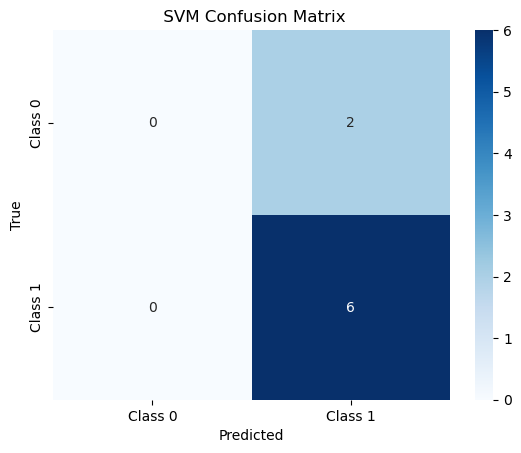

In [71]:
svm_cm = confusion_matrix(newy_test, newy_pred_svm)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(' SVM Confusion Matrix')
plt.show()

SVM produced a decent confusion matrix with no false negatives 

The area under the precision-recall curve is: 0.9436507936507936
The area under the ROC curve is: 0.8333333333333333


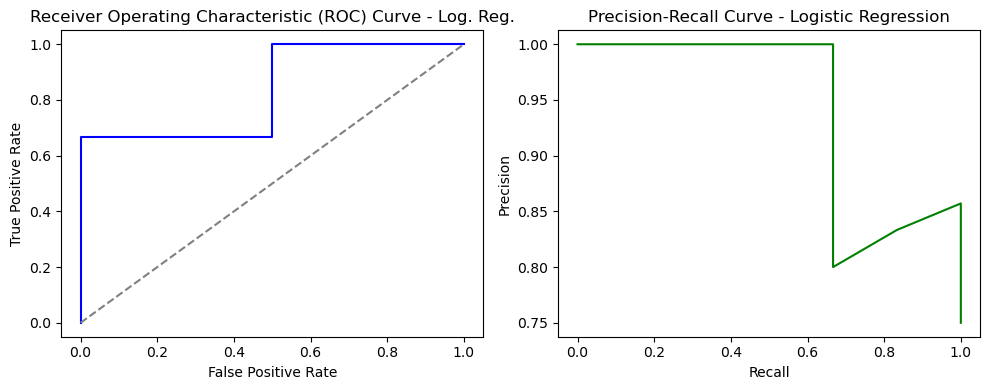

In [50]:
#using ensemble methods to boost the accuracy of classification
#stacking a random forest with a logistic regression classifier

meta_model = LogisticRegression()
log_reg_model = LogisticRegression(max_iter = 30000, random_state=42)
rf_model = RandomForestClassifier(max_depth=3, random_state=42)
stacking_model_lr = StackingClassifier(estimators=[('rf', rf_model), ('log_reg', log_reg_model)], 
                                       final_estimator=meta_model)

stacking_model_lr.fit(newX_train, newy_train)

y_pred_log_reg = stacking_model_lr.predict(newX_test)
y_prob_log_reg = stacking_model_lr.predict_proba(newX_test)[:, 1]

#computing the ROC and precision-recall curves 
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(newy_test, y_prob_log_reg)

precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(newy_test, y_prob_log_reg)

auc_pr_log_reg = auc(recall_log_reg, precision_log_reg)
print('The area under the precision-recall curve is:', auc_pr_log_reg)

roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
print("The area under the ROC curve is:", roc_auc_log_reg)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(fpr_log_reg, tpr_log_reg, color='blue')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve - Log. Reg.')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].plot(recall_log_reg, precision_log_reg, color='green')
axs[1].set_title('Precision-Recall Curve - Logistic Regression')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')


plt.tight_layout()

plt.show()

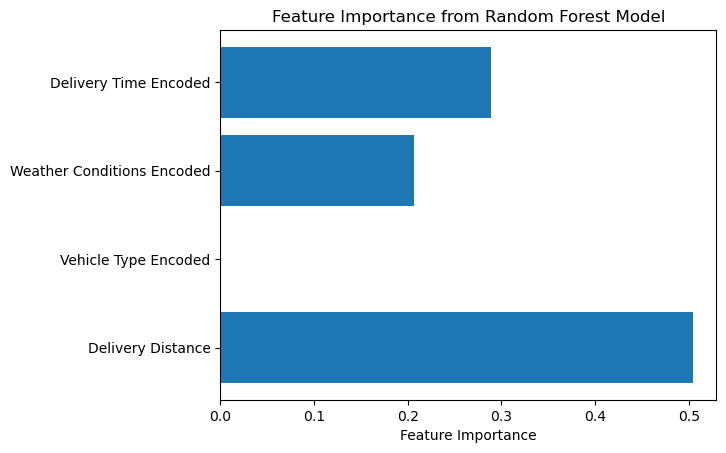

In [51]:
#extracting the feature models from the random forest classifier

rf_model = stacking_model_lr.estimators_[0][1] 
feature_importance_rf = rf_model.feature_importances_
#each features contribution to the variance 

features = newX_train.columns
#sorts the features from most to least important
indices = np.argsort(feature_importance_rf)

plt.barh(indices, feature_importance_rf[indices], align='center')
plt.yticks(indices, features[indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.show()

### Analysis

The best results were achieved when stacking a random forest classifier with a logistic regression model. An ensemble of these two methods worked to increase the AUC ROC and precision-recall scores. Based on the feature importance analysis, I determined that the delivery distance, delivery time, and weather conditions contributed the most to the delay classification. To optimize the route and reduce delays, I would recommend to complete the longer distance deliveries right away, to minimize both delays due to distance travelled and the delivery time. If the further deliveries are done in the morning, we could see a larger drop in the amount of delays reported. Additionally, I would recommend that the bulk of deliveries be done in the morning. Especially if the weather is not ideal, we should see more deliveries going out in the morning, or at a time when it is more ideal. 

# Question 4

In [52]:
bookdf = pd.read_csv('Bestseller_Books.csv')
print(bookdf.shape)
bookdf.head()

(550, 7)


Name  \
0                      10-Day Green Smoothie Cleanse   
1                                  11/22/63: A Novel   
2            12 Rules for Life: An Antidote to Chaos   
3                             1984 (Signet Classics)   
4  5,000 Awesome Facts (About Everything!) (Natio...   

                     Author  User Rating  Reviews  Price  Year        Genre  
0                  JJ Smith          4.7    17350      8  2016  Non Fiction  
1              Stephen King          4.6     2052     22  2011      Fiction  
2        Jordan B. Peterson          4.7    18979     15  2018  Non Fiction  
3             George Orwell          4.7    21424      6  2017      Fiction  
4  National Geographic Kids          4.8     7665     12  2019  Non Fiction

This dataset provides information on the title of bestselling books, the author, user ratings, reviews, prices, the year, and the genre. There are 550 samples and 7 attributes to describe each bestseller. Some potential issues that could arise within this dataset are missing values, outliers, and duplicates, which I will examine in the following cells. 

In [53]:
bookdf.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

There are no missing values here to worry about, but if there were any, I would deal with them in the following ways:
- Name: replace the title, which I assume would be a nan, with 'Unknown', or delete the sample from the dataset if a missing title didn't contribute to many missing values 
- Author: if it's a nan, replace with 'Unknown', or delete the sample from the dataset if a missing author didn't contribute to many missing values 
- User rating: replace with the mean, or median for skewed data
- Reviews: replace with the mean, or median for skewed data
- Price: replace with the mean, or median for skewed data
- Year: replace with an integer value of the mean, or median for skewed data
- Genre: replace as 'Unknown' for nan, or delete the sample from the dataset if a missing genre didn't contribute to many missing values 

In [54]:
#adjusting the given data to remove outliers using the IQR method 
#if i wanted to compare two models with outliers, I would eliminate the top and bottom five instead 
#so that the attributes are still the same size when graphing

review_quant_upper = bookdf['Reviews'].quantile(0.75)
review_quant_lower = bookdf['Reviews'].quantile(0.25)
review_iqr = review_quant_upper - review_quant_lower
review_outlier_lower_range = review_quant_lower - 1.5 * review_iqr
review_outlier_upper_range = review_quant_upper + 1.5 * review_iqr
reviews_outlier_lower = bookdf['Reviews'][bookdf['Reviews'] < review_outlier_lower_range]
reviews_outlier_upper = bookdf['Reviews'][bookdf['Reviews'] > review_outlier_upper_range]
reviews_no_outliers = bookdf['Reviews'][bookdf['Reviews'] < min(reviews_outlier_upper)]

rating_quant_upper = bookdf['User Rating'].quantile(0.75)
rating_quant_lower = bookdf['User Rating'].quantile(0.25)
rating_iqr = rating_quant_upper - rating_quant_lower
rating_outlier_lower_range = rating_quant_lower - 1.5 * rating_iqr
rating_outlier_upper_range = rating_quant_upper + 1.5 * rating_iqr
rating_outlier_lower = bookdf['User Rating'][bookdf['User Rating'] < rating_outlier_lower_range]
rating_outlier_upper = bookdf['User Rating'][bookdf['User Rating'] > rating_outlier_upper_range]
rating_no_outliers = bookdf['User Rating'][bookdf['User Rating'] > max(rating_outlier_lower)]

price_quant_upper = bookdf['Price'].quantile(0.75)
price_quant_lower = bookdf['Price'].quantile(0.25)
price_iqr = price_quant_upper - price_quant_lower
price_outlier_lower_range = price_quant_lower - 1.5 * price_iqr
price_outlier_upper_range = price_quant_upper + 1.5 * price_iqr
price_outlier_lower = bookdf['Price'][bookdf['Price'] < price_outlier_lower_range]
price_outlier_upper = bookdf['Price'][bookdf['Price'] > price_outlier_upper_range]
price_no_outliers = bookdf['Price'][bookdf['Price'] < min(price_outlier_upper)]

year_quant_upper = bookdf['Year'].quantile(0.75)
year_quant_lower = bookdf['Year'].quantile(0.25)
year_iqr = year_quant_upper - year_quant_lower
year_outlier_lower_range = year_quant_lower - 1.5 * year_iqr
year_outlier_upper_range = year_quant_upper + 1.5 * year_iqr
year_outlier_lower = bookdf['Year'][bookdf['Year'] < year_outlier_lower_range]
year_outlier_upper = bookdf['Year'][bookdf['Year'] > year_outlier_upper_range]

In [55]:
#looking to see if there are books listed in the dataframe more than once

bookdf[bookdf['Name'].map(bookdf['Name'].value_counts()) > 1]
#it looks like the reason that books repeat is because of the year 
#bestsellers year after year 

Name           Author  \
9                            A Man Called Ove: A Novel  Fredrik Backman   
10                           A Man Called Ove: A Novel  Fredrik Backman   
20                         All the Light We Cannot See    Anthony Doerr   
21                         All the Light We Cannot See    Anthony Doerr   
32                                            Becoming   Michelle Obama   
..                                                 ...              ...   
544                                             Wonder    R. J. Palacio   
546  You Are a Badass: How to Stop Doubting Your Gr...      Jen Sincero   
547  You Are a Badass: How to Stop Doubting Your Gr...      Jen Sincero   
548  You Are a Badass: How to Stop Doubting Your Gr...      Jen Sincero   
549  You Are a Badass: How to Stop Doubting Your Gr...      Jen Sincero   

     User Rating  Reviews  Price  Year        Genre  
9            4.6    23848      8  2016      Fiction  
10           4.6    23848      8  2017      Fiction  
20           4.6    36348     14  2014      Fiction  
21           4.6    36348     14  2015      Fiction  
32           4.8    61133     11  2018  Non Fiction  
..           ...      ...    ...   ...          ...  
544          4.8    21625      9  2017      Fiction  
546          4.7    14331      8  2016  Non Fiction  
547          4.7    14331      8  2017  Non Fiction  
548          4.7    14331      8  2018  Non Fiction  
549          4.7    14331      8  2019  Non Fiction  

[295 rows x 7 columns]

In [56]:
#grouping the books by the name and the most recent year they were on the bestselling list
#most accurately represents book popularity over time 

bookdf = bookdf.loc[bookdf.groupby('Name')['Year'].idxmax()]
bookdf.shape

#reduces the number of samples in the data set by nearly 200 

(351, 7)

In [57]:
max(bookdf['Name'].value_counts())

#making sure that no book title appears more than once 

1

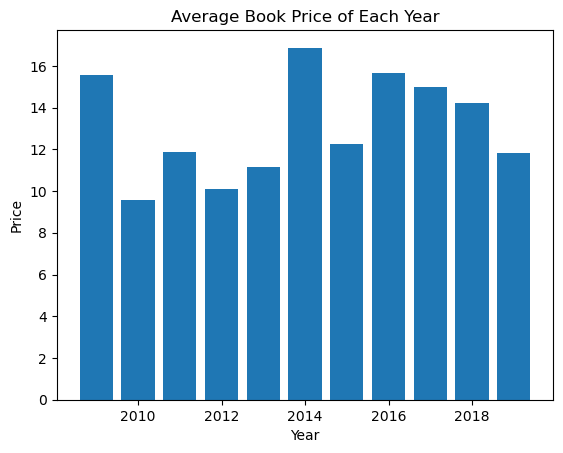

In [58]:
average_price = bookdf.groupby('Year')['Price'].mean()

plt.bar(bookdf['Year'].unique(), average_price)
plt.title('Average Book Price of Each Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

The only pattern I can discern from this dataset is that in general, the prices of books have gone up between 2009-2019. This makes sense that generally, inflation grows from year to year. There are outlier years including 2009 and 2014 where the average price of books was much higher than to be expected. This graph doesn't provide any information as to why this happens, but it could be discovered by looking at economic and political trends during those years. 

Genre
Fiction        4.615625
Non Fiction    4.603665
Name: User Rating, dtype: float64


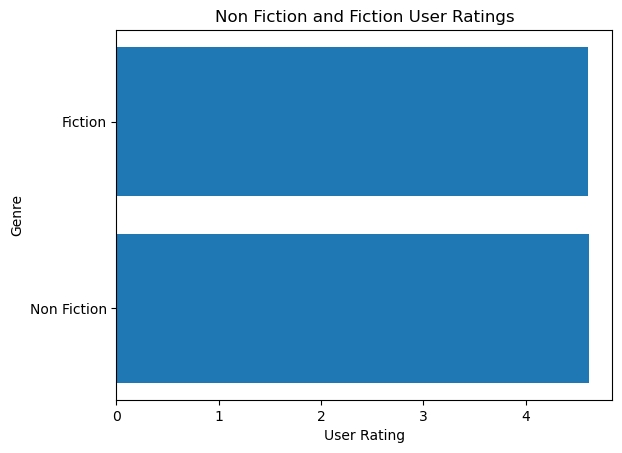

In [59]:
average_ratings = bookdf.groupby('Genre')['User Rating'].mean()
print(average_ratings)
plt.barh(bookdf['Genre'].unique(), average_ratings)
plt.title('Non Fiction and Fiction User Ratings')
plt.ylabel('Genre')
plt.xlabel('User Rating')
plt.show()

We see from this graph that the difference in user ratings between non fiction books and fiction is extremely minimal. Fiction leads in average user ratings by 0.01. So from the information presented, there is no clear genre preferences between the users that left ratings. 

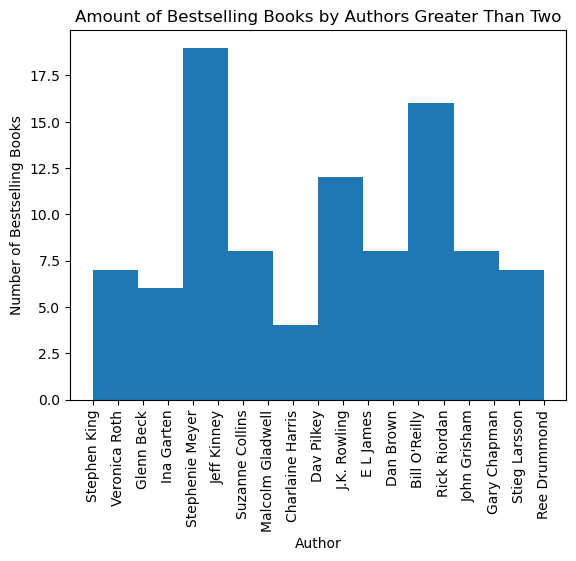

In [60]:
bookdf['Author'][bookdf['Author'].map(bookdf['Author'].value_counts()) > 1]
plt.hist(bookdf['Author'][bookdf['Author'].map(bookdf['Author'].value_counts()) > 2])
plt.xticks(rotation=90)
plt.title('Amount of Bestselling Books by Authors Greater Than Two')
plt.xlabel('Author')
plt.ylabel('Number of Bestselling Books')
plt.show()

This graph represents the number of bestselling books by a repeating performance author. In other words, I filtered out the others that had just one book on the bestsellers list. It appears like the average number of bestselling books for these authors hovers around 7-8, with outliers Jeff Kinney and Rick Riordan having 18 and 16 bestselling books respectively. 

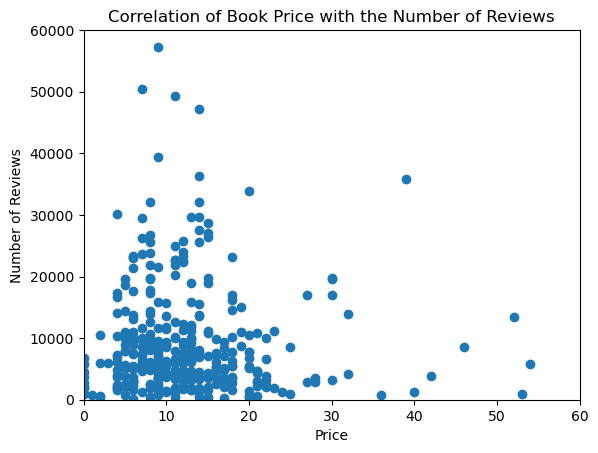

In [61]:
plt.scatter(bookdf['Price'], bookdf['Reviews'])
plt.title('Correlation of Book Price with the Number of Reviews')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.xlim(0,60)
plt.ylim(0, 60000)
plt.show()

I eliminated the outliers from this graph by adjusting the y and x axis limits to get a better visual as to the correlations of the majority of the data. The highest density of reviews left happens when the books are priced between $7-18. The least density occurs when the books are prices over $30. This generally makes sense because more people are going to read books that are less expensive and therefore leave reviews. With less people reading expensive books, the less reviews those books will have.

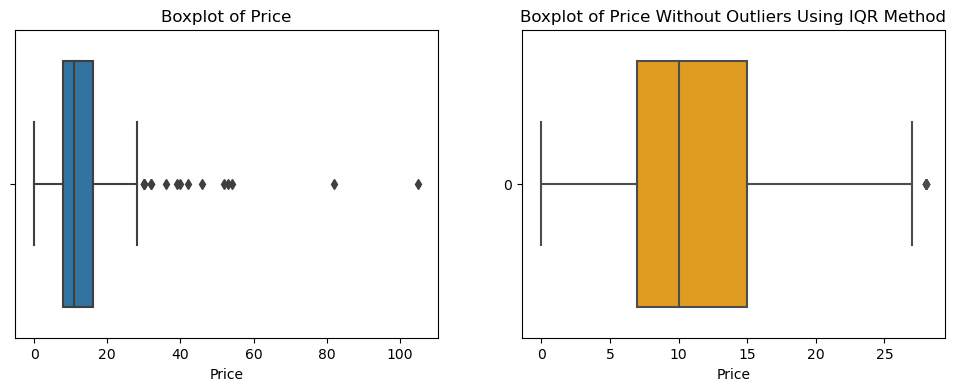

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=bookdf, x='Price', ax=ax[0])
sns.boxplot(data=price_no_outliers, ax=ax[1], color='orange', orient='h')
ax[0].set_title('Boxplot of Price')
ax[1].set_title('Boxplot of Price Without Outliers Using IQR Method')
ax[1].set_xlabel('Price')

plt.show()

The two box plots represent the range in price of the books on the bestsellers list. When we include outliers, we can tell that the majority of bestselling books are less than $20, but since the plot is smooshed, its hard to extract more detailed information. The plot on the right represents the range of prices without outliers from using the IQR method in previous cells. Here, it's clear that most of the books are priced around $7-15. 

In [63]:
#creating a pivot table to extract information on the amount of each genre that makes the bestselling list each
#year 

table = pd.pivot_table(bookdf, index=['Year'], columns=['Genre'], aggfunc='count', values='Name')
table

Genre  Fiction  Non Fiction
Year                       
2009        20           18
2010        14           19
2011        15           12
2012        14           18
2013        13           15
2014        20           10
2015         9           19
2016         9           17
2017        13           16
2018        13           17
2019        20           30

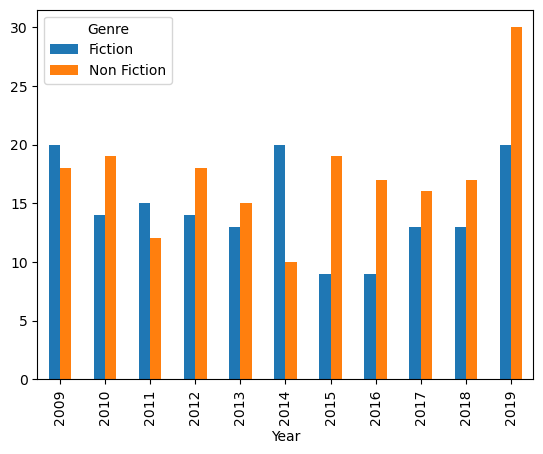

In [64]:
table.plot(kind='bar')
plt.show()

It's clear that normally more nonfiction books make the bestselling each year than fiction books. Aside from the years 2014, 2011, and 2009. This is an interesting trend because we also saw that the price of books was much higher in 2014 and 2009, so this information could be an indicator as to why

Genre
Fiction        12.100000
Non Fiction    13.701571
Name: Price, dtype: float64


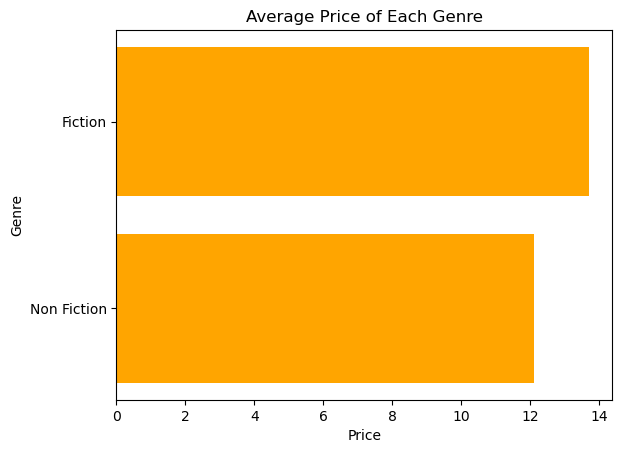

In [65]:
average_genre_price = bookdf.groupby('Genre')['Price'].mean()
print(average_genre_price)
plt.barh(bookdf['Genre'].unique(), average_genre_price, color='orange')
plt.title('Average Price of Each Genre')
plt.xlabel('Price')
plt.ylabel('Genre')
plt.show()

I wanted to continue exploring the association between the genre and price and see that the average price of fiction books is greater than nonfiction by almost two dollars. This tells me that the increased popularity of fiction books in 2014 and 2009 correlate with the increase in book prices during those years. 

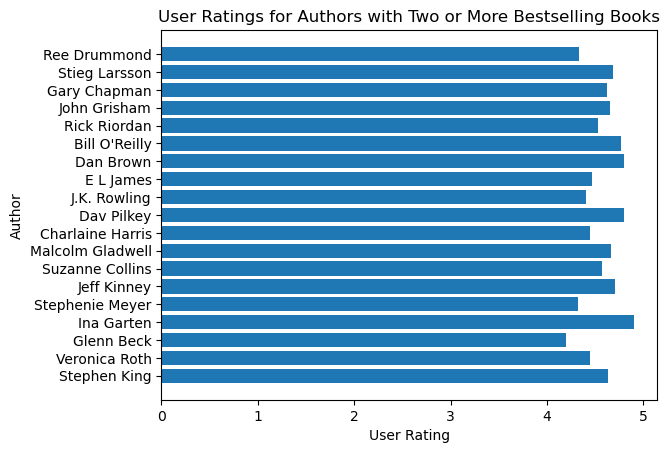

In [66]:
filtered = bookdf[bookdf['Author'].map(bookdf['Author'].value_counts()) > 2]
filtered = filtered.loc[filtered.groupby('Name')['Year'].idxmax()]

average_author_ratings = filtered.groupby('Author')['User Rating'].mean()
plt.barh(filtered['Author'].unique(), average_author_ratings)
plt.title('User Ratings for Authors with Two or More Bestselling Books')
plt.xlabel('User Rating')
plt.ylabel('Author')
plt.show()

This graph illustrates the association between the authors with two or more bestselling books during the years 2009-2019 and their overall user rating. In a previous graph, we saw that Rick Riordan and Jeff Kinney had the most published books on the bestselling list, yet have some of the lowest user rating scores. This seems bound to happen as an author publishes more books, more people read their work, and leave ratings. 

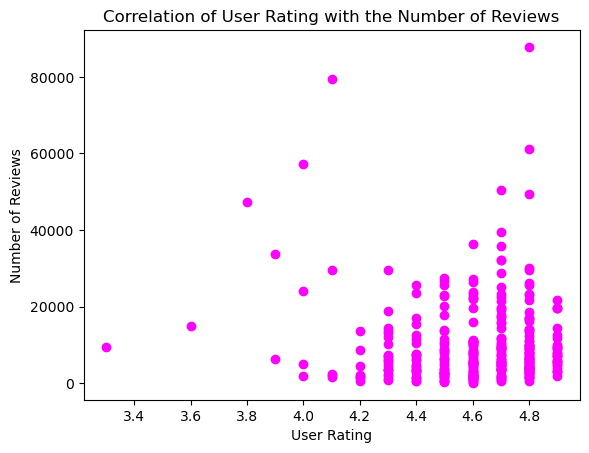

In [67]:
plt.scatter(bookdf['User Rating'], bookdf['Reviews'], color='magenta')
plt.title('Correlation of User Rating with the Number of Reviews')
plt.xlabel('User Rating')
plt.ylabel('Number of Reviews')
plt.show()

Next, I wanted to see if there was any association between the user rating and the number of reviews. Generally, as the user rating increases, so does the number of reviews up until 4.7-4.8. This makes sense given that the less people who read a book and leave a review, the less potentially negative user ratings there will be.

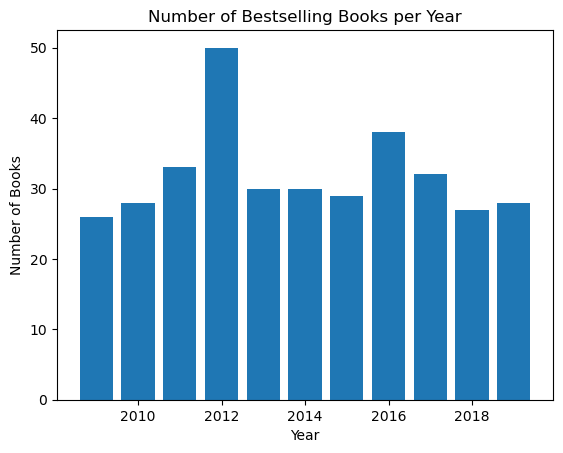

In [68]:
books_per_year = bookdf.groupby('Year').size()
plt.bar(bookdf['Year'].unique(), books_per_year)
plt.title('Number of Bestselling Books per Year')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.show()

Here, I wanted to see if the number of books that made it on the bestselling list changed from year to year. It's a pretty uniform distribution aside from the years 2012 and 2016. However, nothing on this graph indicates the case for this. 

### Analysis

From the visualized data, we can describe some deliverables: 
- Price recommendations should generally follow the inflation rate of the year for nonfiction books, and fiction books should be priced around two dollars more than nonfiction 
- There's no clear genre preferences between fiction and nonfiction of readers who left user ratings 
- The more books an author has on the bestseller list, the lower their user rating score will be - the authors we see with two or more books on this bestseller list write book series
- Books seem to get the most reviews when they're priced around 10-12 dollars - increased ease of access to the book leads to more people reading it and leaving reviews 